# Integration of CITE-seq and scRNA-seq data

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import scvi
from scipy.stats import pearsonr

/home/adam/Documents/software/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/home/adam/Documents/software/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.


## Imports and data loading

In [2]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [3]:
adata = scvi.data.pbmcs_10x_cite_seq()

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                                                     
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                                      


/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1    PBMC10k
AAACCCACATCGGTTA-1    PBMC10k
AAACCCAGTACCGCGT-1    PBMC10k
AAACCCAGTATCGAAA-1    PBMC10k
AAACCCAGTCGTCATA-1    PBMC10k
                       ...   
TTTGGTTGTACGAGTG-1     PBMC5k
TTTGTTGAGTTAACAG-1     PBMC5k
TTTGTTGCAGCACAAG-1     PBMC5k
TTTGTTGCAGTCTTCC-1     PBMC5k
TTTGTTGCATTGCCGG-1     PBMC5k
Name: batch, Length: 10849, dtype: object

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [5]:
held_out_proteins = adata.obsm["protein_expression"][batch == "PBMC5k"].copy()
adata.obsm["protein_expression"].loc[batch == "PBMC5k"] = np.zeros_like(
    adata.obsm["protein_expression"][batch == "PBMC5k"]
)

In [6]:
sc.pp.highly_variable_genes(
    adata, batch_key="batch", flavor="seurat_v3", n_top_genes=4000, subset=True
)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


<div class="alert alert-info">

Important

scvi-tools will automatically detect proteins as missing in a certain batch if the protein has 0 counts for each cell in the batch. In other words, to indicate a protein is missing in a certain batch, please set it to 0 for each cell.

</div>

In [7]:
scvi.model.TOTALVI.setup_anndata(
    adata, batch_key="batch", protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                                       
INFO     Found batches with missing protein expression                                                             


## Prepare and run model

In [8]:
model = scvi.model.TOTALVI(adata, latent_distribution="normal", n_layers_decoder=2)

INFO     Computing empirical prior initialization for protein background.                                          


/tmp/ipykernel_1137503/3261033344.py:1: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.


In [9]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:309: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.


Epoch 330/400:  82%|████████▎ | 330/400 [03:04<00:39,  1.79it/s, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1246.795. Signaling Trainer to stop.


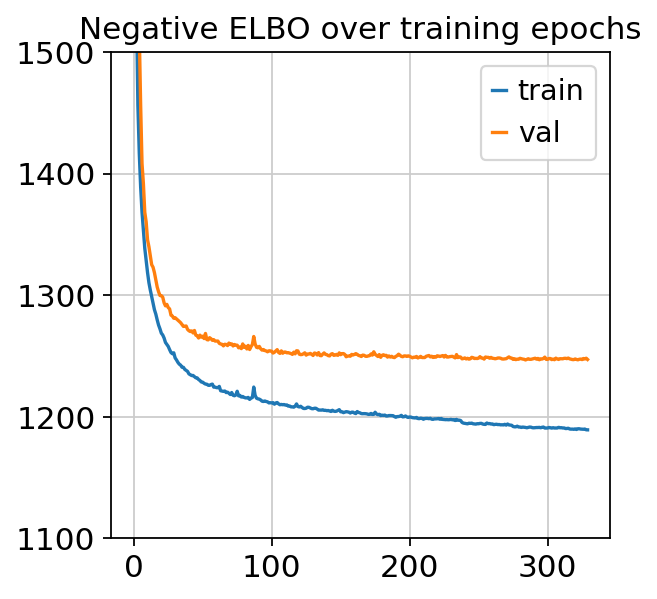

In [10]:
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

Again, we rely on Scanpy.

In [11]:
adata.obsm["X_totalVI"] = model.get_latent_representation()
adata.obsm["protein_fg_prob"] = model.get_protein_foreground_probability(
    transform_batch="PBMC10k"
)

rna, protein = model.get_normalized_expression(
    transform_batch="PBMC10k", n_samples=25, return_mean=True
)

```{note}
`transform_batch` is a powerful parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we've observed protein expression in batch "PBMC10k" (batch categories from original adata object), but we have no protein expression in batch "PBMC5k". We'd like to take the cells of batch "PBMC5k" and make a counterfactual prediction: "What would the expression look like if my batch "PBMC5k" cells came from batch "PBMC10k"?"
```

In [12]:
protein.iloc[:5, :5]

CD3_TotalSeqB  CD4_TotalSeqB  CD8a_TotalSeqB   
index                                                              
AAACCCAAGATTGTGA-1      14.844885     311.460083        3.637398  \
AAACCCACATCGGTTA-1      31.621244     169.105698        1.837450   
AAACCCAGTACCGCGT-1      13.879414     352.262573       10.316340   
AAACCCAGTATCGAAA-1       9.842157      10.861034       38.662792   
AAACCCAGTCGTCATA-1       2.339897       0.231464       65.773094   

                    CD14_TotalSeqB  CD15_TotalSeqB  
index                                               
AAACCCAAGATTGTGA-1     1081.757080      114.455605  
AAACCCACATCGGTTA-1      656.323914      101.242943  
AAACCCAGTACCGCGT-1     1168.909058      111.649437  
AAACCCAGTATCGAAA-1        0.521565      130.835526  
AAACCCAGTCGTCATA-1        0.022398       97.442101

```{important}
The following is for illustrative purposes. In the code blocks above, we have the denoised protein values for each cell. These values have the expected protein background component removed. However, to compare to the held out protein values, we must include both protein foreground and background. We recommend using the values above for downstream tasks.
```

In [13]:
_, protein_means = model.get_normalized_expression(
    n_samples=25,
    transform_batch="PBMC10k",
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [14]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


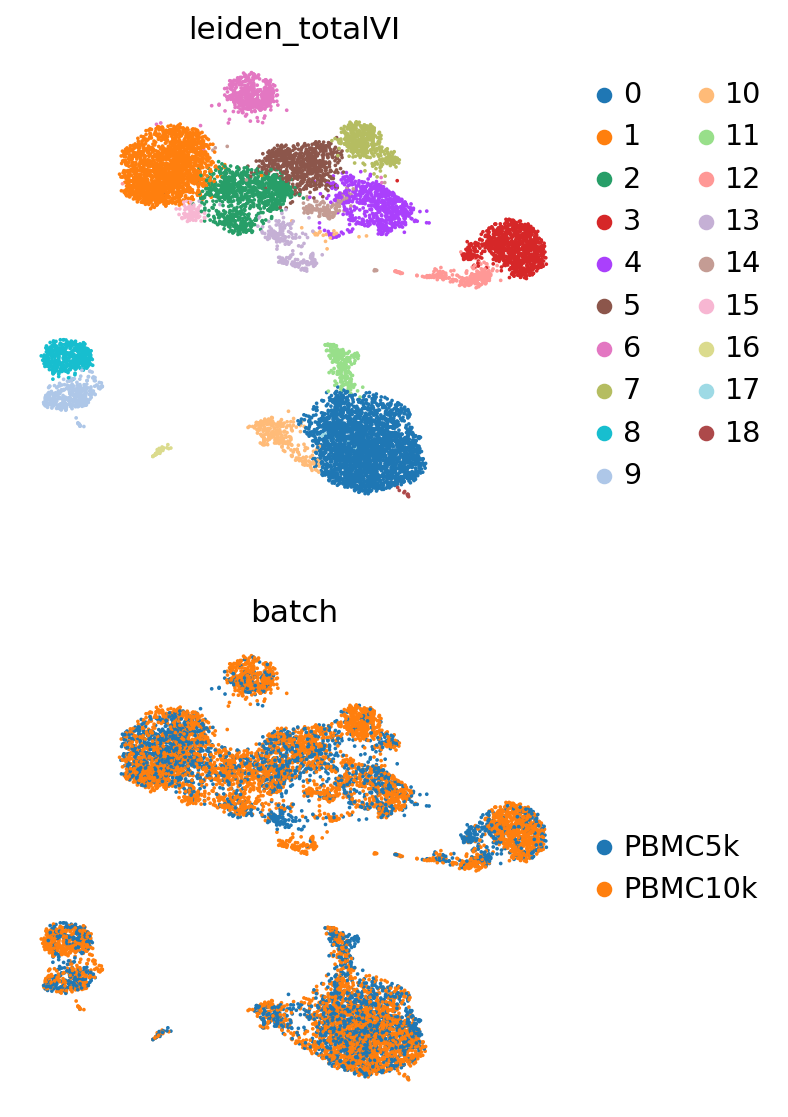

In [15]:
perm_inds = np.random.permutation(len(adata))
sc.pl.umap(
    adata[perm_inds],
    color=["leiden_totalVI", "batch"],
    ncols=1,
    frameon=False,
)

In [16]:
batch = adata.obs.batch.values.ravel()
combined_protein = np.concatenate(
    [adata.obsm["protein_expression"].values[batch == "PBMC10k"], held_out_proteins],
    axis=0,
)

# cleaner protein names
parsed_protein_names = [
    p.split("_")[0] for p in adata.obsm["protein_expression"].columns
]
for i, p in enumerate(parsed_protein_names):
    adata.obs[f"{p} imputed"] = protein_means.iloc[:, i]
    adata.obs[f"{p} observed"] = combined_protein[:, i]

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


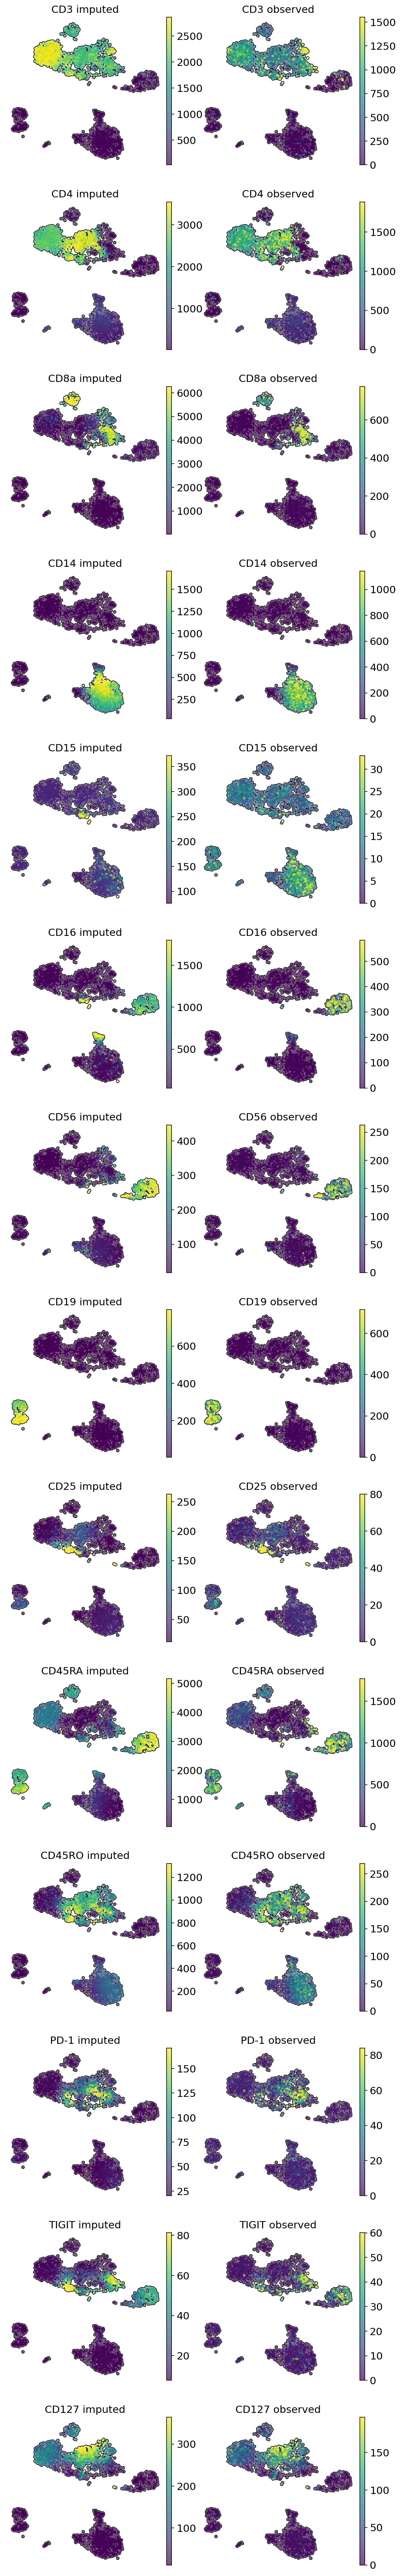

In [17]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    adata[adata.obs.batch == "PBMC5k"],
    color=viz_keys,
    ncols=2,
    vmax="p99",
    frameon=False,
    add_outline=True,
    wspace=0.1,
)

## Imputed vs denoised correlations

In [18]:
imputed_pros = protein_means[batch == "PBMC5k"]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(
        parsed_protein_names[i]
        + ": Corr="
        + str(
            np.round(
                pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3
            )
        )
    )
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)           Protein
0        3.258097       3.487056   CD3: Corr=0.788
1        5.105945       5.985243    CD4: Corr=0.87
2        2.833213       3.528627   CD8a: Corr=0.81
3        6.546785       7.194500  CD14: Corr=0.906
4        2.995732       4.767605  CD15: Corr=0.108

We notice that CD15 has a really low correlation (imputation accuracy). Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


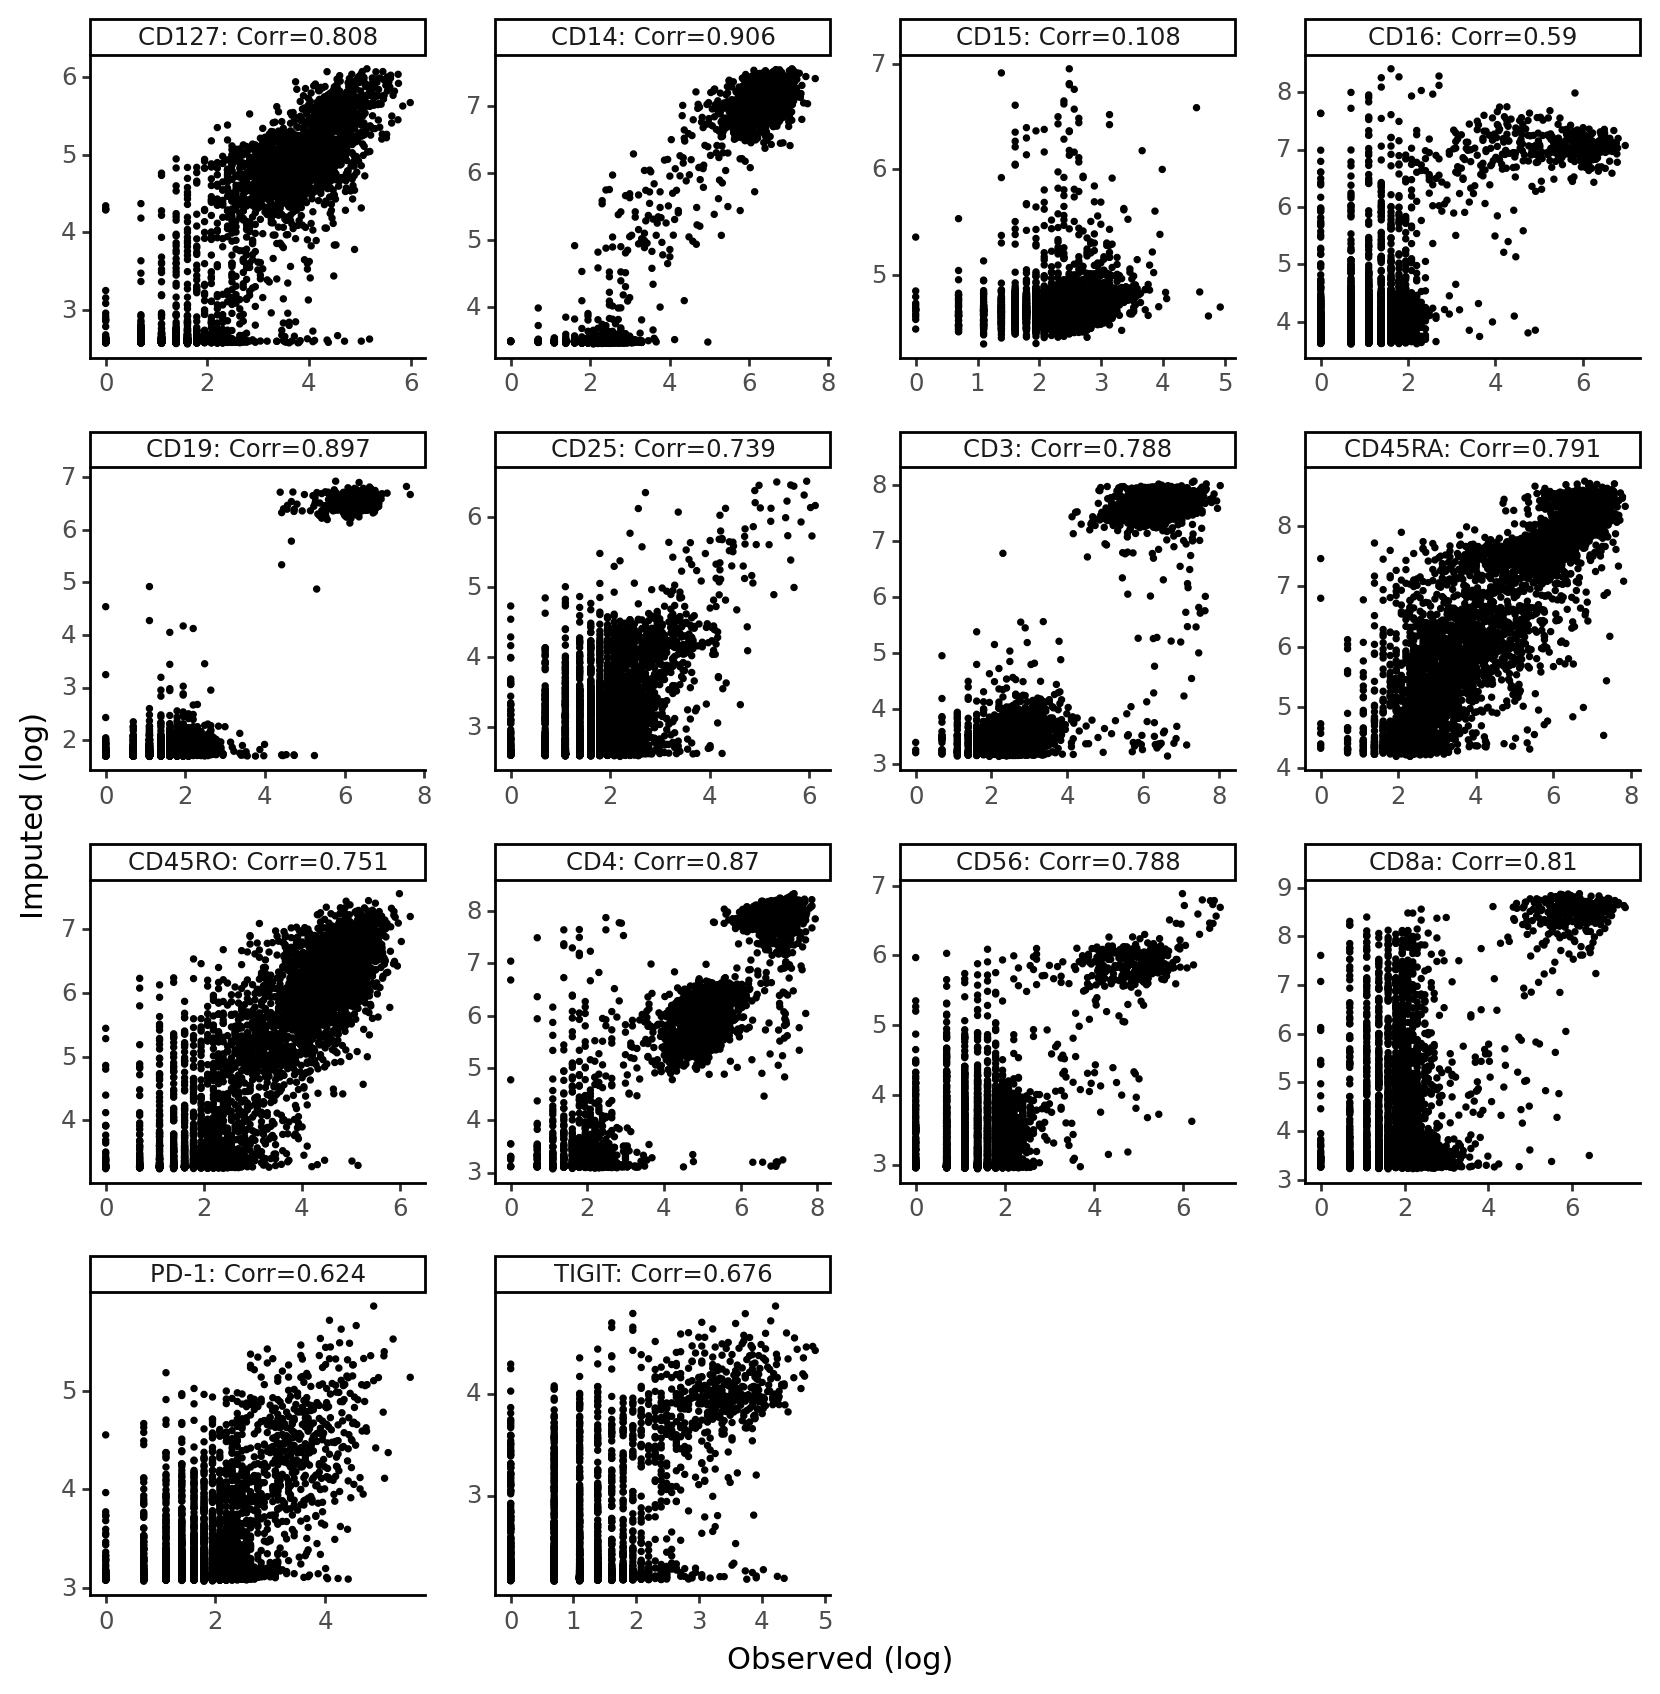

<ggplot: (8754221977510)>

In [19]:
p9.theme_set(p9.theme_classic)
(
    p9.ggplot(held_vs_denoised, p9.aes("Observed (log)", "Imputed (log)"))
    + p9.geom_point(size=0.5)
    + p9.facet_wrap("~Protein", scales="free")
    + p9.theme(
        figure_size=(10, 10),
        panel_spacing=0.35,
    )
)